In [89]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки
plt.style.use('seaborn')

In [90]:
data = pd.read_csv('../../data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [91]:
print(data.shape)
# (1338, 7)

(1338, 7)


нет пропусков

In [92]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [94]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


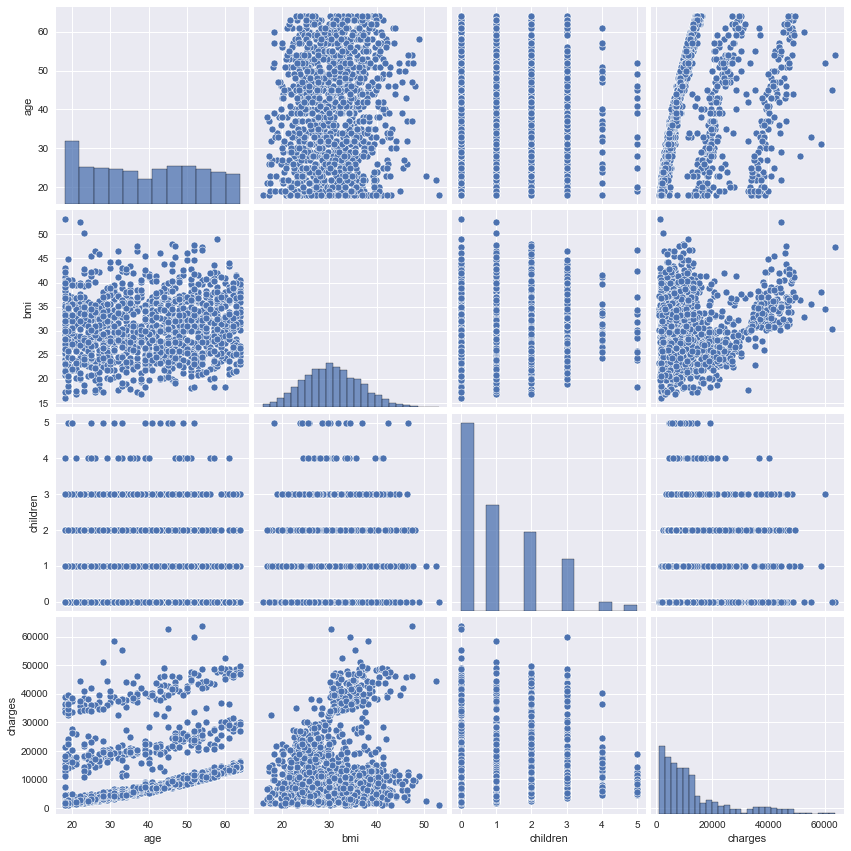

In [95]:
sns.pairplot(data=data, size=3)

In [96]:
num_cols = [col for col in data.columns if data[col].dtypes != 'object']
obj_cols = [col for col in data.columns if data[col].dtypes == 'object']

In [97]:
sex_smoke = data[data['smoker']=='yes'].groupby(['sex', 'children'])['smoker'].count()
sex_smoke


sex     children
female  0           53
        1           25
        2           22
        3           14
        5            1
male    0           62
        1           36
        2           33
        3           25
        4            3
Name: smoker, dtype: int64

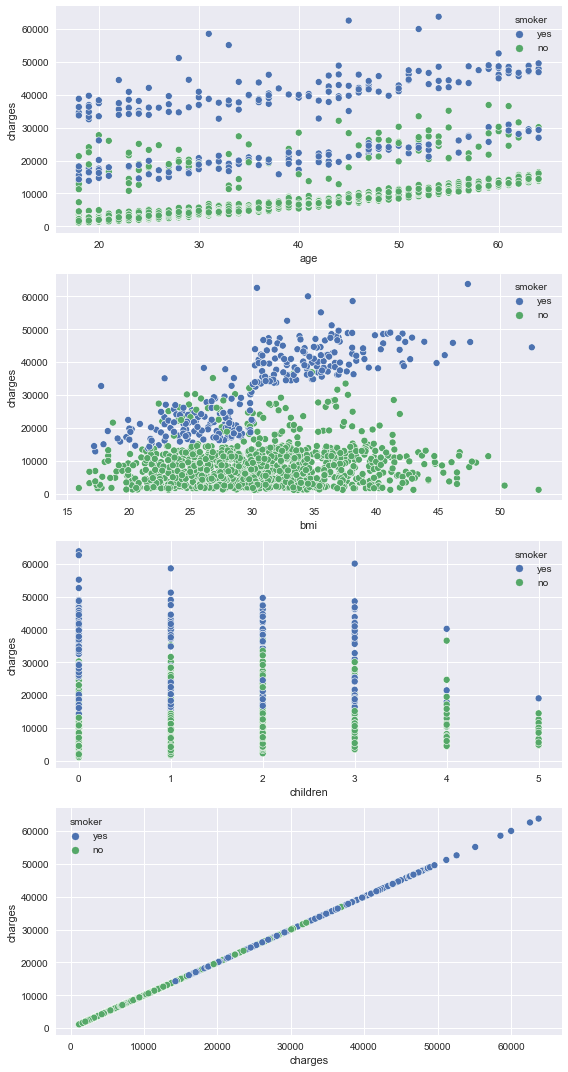

In [98]:
fig, ax = plt.subplots(4,1, figsize=(8,15))
for i, col in enumerate(num_cols):
    sns.scatterplot(data=data, x=col, y='charges', hue='smoker', ax=ax[i])
    ax[i].set_xlabel(col)
fig.tight_layout()

всё на лицо

In [99]:
data['smoker'] = data['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
data['sex'] = data['sex'].apply(lambda x: 1 if x == 'male' else 0)
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [100]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

<AxesSubplot:>

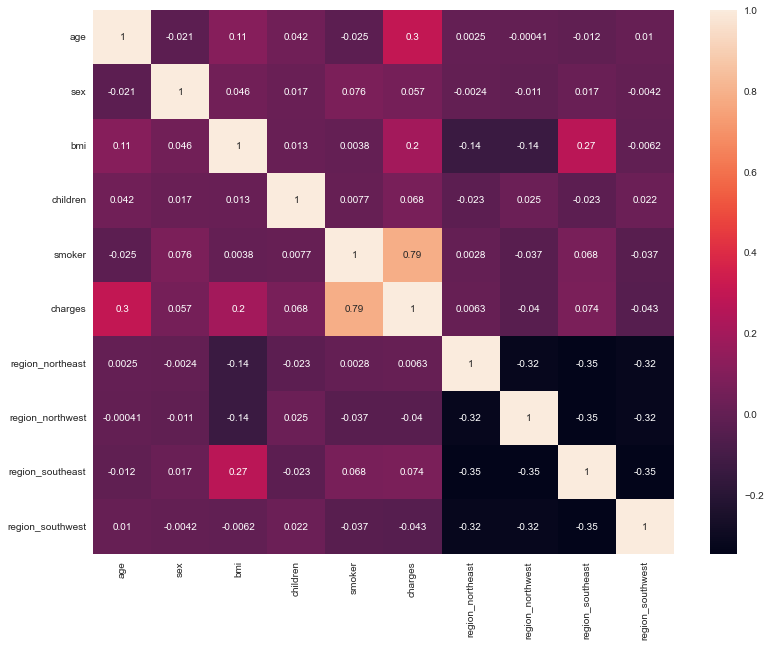

In [101]:
plt.figure(figsize=(13,10))
sns.heatmap(data.corr(), annot=True)

Моделирование

In [102]:
def print_metrics(train_pred, train_true, test_pred, test_true):
    print(f'R^2 train: {metrics.r2_score(train_true, train_pred)}')
    print(f'MAE train: {metrics.mean_absolute_error(train_true, train_pred)}')
    print(f'MAPE train: {metrics.mean_absolute_percentage_error(train_true, train_pred)*100}')
    print()
    print(f'R^2 test: {metrics.r2_score(test_true, test_pred)}')
    print(f'MAE test: {metrics.mean_absolute_error(test_true, test_pred)}')
    print(f'MAPE test: {metrics.mean_absolute_percentage_error(test_true, test_pred)*100}')

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(1070, 9) (268, 9)


# baseline

In [104]:
lg_model = linear_model.LinearRegression()
lg_model.fit(X_train,y_train)
train_pred = lg_model.predict(X_train)
test_pred = lg_model.predict(X_test)
print_metrics(train_pred, y_train, test_pred, y_test)

R^2 train: 0.7417255854683333
MAE train: 4208.234572492217
MAPE train: 42.202685080316265

R^2 test: 0.7835929767120723
MAE test: 4181.194473753641
MAPE test: 46.8882559791466


In [105]:
lg_model.intercept_

-12390.804294570278

c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot:>

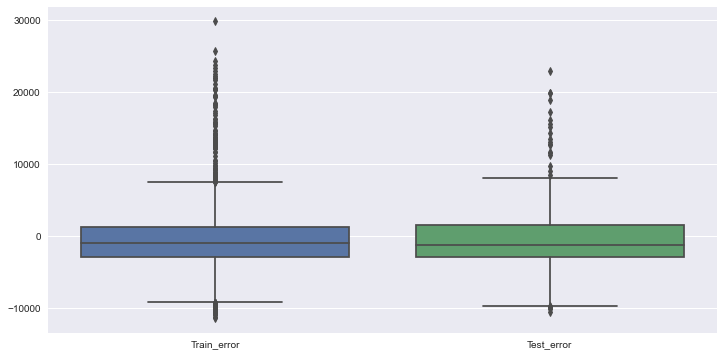

In [107]:
train_error = y_train - train_pred
test_error = y_test - test_pred 
errors_df = pd.DataFrame({
    'Train_error': train_error,
    'Test_error': test_error
})
plt.figure(figsize=(12,6))
sns.boxplot(data=errors_df)

# min_max scale

In [112]:
lr_on_normal = linear_model.LinearRegression()

In [108]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [109]:
poly = preprocessing.PolynomialFeatures(include_bias=False)
poly.fit(X_train_scaled)
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)


In [110]:
X_train_scaled_poly.shape

(1070, 54)

In [114]:
lr_on_normal.fit(X_train_scaled_poly, y_train)
train_pred_poly = lr_on_normal.predict(X_train_scaled_poly)
test_pred_poly = lr_on_normal.predict(X_test_scaled_poly)
print_metrics(train_pred_poly, y_train, test_pred_poly, y_test)


R^2 train: 0.8418129021995029
MAE train: 2906.1200006635513
MAPE train: 29.615189294518025

R^2 test: 0.8665223490372533
MAE test: 2741.678052794776
MAPE test: 30.411491272309437


# Модель переобучена (неустойчива)

In [115]:
lr_on_normal.coef_

array([-3.51760358e+16,  1.61021746e+15,  2.47615914e+15, -4.81004112e+15,
        1.29275952e+14, -3.52012791e+15, -2.48431178e+15, -2.59881721e+15,
       -1.45044066e+15,  8.44800000e+03,  8.02000000e+02,  9.72000000e+02,
       -1.67600000e+03,  1.70000000e+02,  3.51760358e+16,  3.51760358e+16,
        3.51760358e+16,  3.51760358e+16, -9.23535566e+14,  6.51750000e+02,
       -1.23750000e+03,  2.63000000e+02, -6.86681899e+14, -6.86681899e+14,
       -6.86681899e+14, -6.86681899e+14, -9.69775000e+03,  1.55693750e+03,
        5.48399844e+04, -2.47615914e+15, -2.47615914e+15, -2.47615914e+15,
       -2.47615914e+15, -2.09825000e+03, -2.23150000e+03,  4.81004112e+15,
        4.81004112e+15,  4.81004112e+15,  4.81004112e+15,  2.54047741e+13,
       -1.54680726e+14, -1.54680726e+14, -1.54680726e+14, -1.54680726e+14,
       -1.14203819e+15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.17785432e+15,  0.00000000e+00,  0.00000000e+00, -2.06334889e+15,
        0.00000000e+00, -

# регуляризация

In [116]:
lasso_lr = linear_model.Lasso(max_iter=2000)
lasso_lr.fit(X_train_scaled_poly, y_train)
lasso_train_pred = lasso_lr.predict(X_train_scaled_poly)
lasso_test_pred = lasso_lr.predict(X_test_scaled_poly)
print_metrics(lasso_train_pred, y_train, lasso_test_pred, y_test)

R^2 train: 0.8417762232472386
MAE train: 2890.473251890696
MAPE train: 29.40124966351171

R^2 test: 0.8668072143180998
MAE test: 2719.3341297308816
MAPE test: 30.069898575817533


c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.216e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.230e+09, tolerance: 1.544e+07
  model = cd_fast.enet_coordinate_descent(
c:\Users\mblyz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

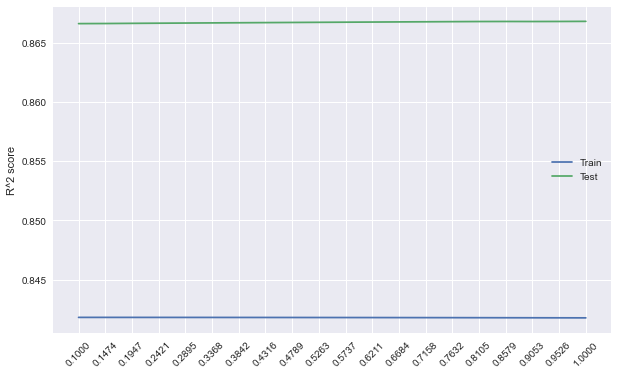

In [122]:
alpha_list = np.linspace(0.1, 1, 20)
train_scores = []
test_scores = []
for alpha in alpha_list:
    lasso_lr = linear_model.Lasso(alpha=alpha,max_iter=2000)
    lasso_lr.fit(X_train_scaled_poly, y_train)
    lasso_train_pred = lasso_lr.predict(X_train_scaled_poly)
    lasso_test_pred = lasso_lr.predict(X_test_scaled_poly)
    train_scores.append(metrics.r2_score(y_train, lasso_train_pred))
    test_scores.append(metrics.r2_score(y_test, lasso_test_pred))
fig, axes = plt.subplots(figsize=(10,6))  
axes.plot(alpha_list, train_scores, label='Train') 
axes.plot(alpha_list, test_scores, label='Test') 
axes.set_ylabel("R^2 score")
axes.set_xticks(alpha_list)
axes.xaxis.set_tick_params(rotation=45)
axes.legend();
 

In [117]:
lasso_lr.coef_

array([ 3.24221653e+03, -4.92313816e+02,  5.07612317e+03,  4.58362056e+03,
        1.97928569e+03,  1.88025707e+02, -4.70775218e+02,  5.83657101e+02,
       -2.43543456e+02,  8.29826751e+03,  7.74581954e+02,  8.44448593e+02,
       -1.20775688e+03,  1.34809915e+02, -1.04309726e+03, -0.00000000e+00,
        1.16964229e+03,  1.61765564e+03, -0.00000000e+00,  5.05847740e+02,
       -1.13425152e+03,  2.65796922e+02, -1.22240479e+03,  0.00000000e+00,
        2.36213242e+02, -5.80031340e+02, -8.17963257e+03,  1.29487768e+03,
        5.47148553e+04,  3.58531873e+03,  2.40690210e+03, -9.63549427e+02,
        0.00000000e+00, -1.67464337e+03, -2.05436459e+03,  1.94204864e+03,
        1.95394442e+03, -0.00000000e+00, -1.06364416e+03,  8.00606774e+00,
        5.93688978e+02, -0.00000000e+00, -2.30643423e+02,  1.97933477e+03,
        6.31615519e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

In [129]:
Ridge_lr = linear_model.Ridge(alpha= 0.1, max_iter=2000)
Ridge_lr.fit(X_train_scaled_poly, y_train)
Ridge_train_pred = Ridge_lr.predict(X_train_scaled_poly)
Ridge_test_pred = Ridge_lr.predict(X_test_scaled_poly)
print_metrics(Ridge_train_pred, y_train, Ridge_test_pred, y_test)

R^2 train: 0.8417645521909918
MAE train: 2891.3139098539596
MAPE train: 29.316979172123908

R^2 test: 0.8665483772478564
MAE test: 2736.6703757793357
MAPE test: 30.15683499325505


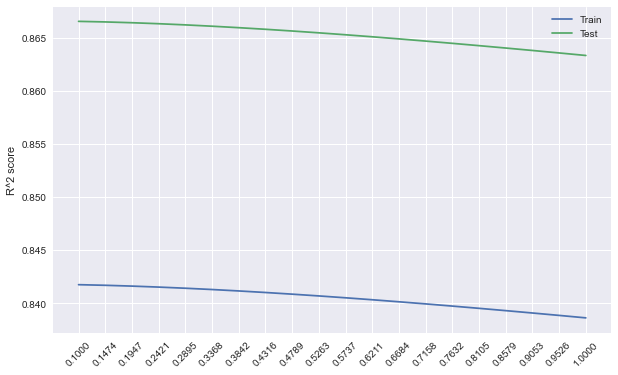

In [131]:
alpha_list = np.linspace(0.1, 1, 20)
train_scores = []
test_scores = []
for alpha in alpha_list:
    lasso_lr = linear_model.Ridge(alpha=alpha,max_iter=2000)
    lasso_lr.fit(X_train_scaled_poly, y_train)
    lasso_train_pred = lasso_lr.predict(X_train_scaled_poly)
    lasso_test_pred = lasso_lr.predict(X_test_scaled_poly)
    train_scores.append(metrics.r2_score(y_train, lasso_train_pred))
    test_scores.append(metrics.r2_score(y_test, lasso_test_pred))
fig, axes = plt.subplots(figsize=(10,6))  
axes.plot(alpha_list, train_scores, label='Train') 
axes.plot(alpha_list, test_scores, label='Test') 
axes.set_ylabel("R^2 score")
axes.set_xticks(alpha_list)
axes.xaxis.set_tick_params(rotation=45)
axes.legend();
 

$\alpha$ = 0.1 оптимально для L2 регуляризации в данном случае